In [2]:
import pandas as pd
import json
import pandas as pd
import time
import sqlite3
import numpy as np 

In [3]:
# create database in DB browser for SQLite
conn = sqlite3.connect("deidatastore.db")
c = conn.cursor()

## Import data

In [4]:
df_text = pd.read_sql(f"""select s.unitid
, unitid_i
, title
, p_text
, p_word_count 
, type
from scrape s

left  join 
(select 
DISTINCT(unitid) as unitid_usnews
, type
from usnews) u

on u.unitid_usnews = s.unitid""", conn)

In [10]:
df_text

,unitid,unitid_i,title,p_text,p_word_count,type
0,150400,150400-0,Diversity and Inclusion,DePauw will becomea more fully inclusive unive...,217,liberal-arts
1,150400,150400-1,Institutional Equity,DePauw will becomea more fully inclusive unive...,217,liberal-arts
2,183071,183071-0,Diversity & Inclusion,We strive to create a collegial and supportive...,1572,liberal-arts
3,166027,166027-0,Diversity and Inclusion,"Together, we strive to create an environment t...",308,research
4,232681,232681-0,Diversity & Inclusion,We're committed to creating a community that i...,36,liberal-arts
...,...,...,...,...,...,...
460,195173,195173-3,Diversity,Our academic programs are student-customized i...,574,liberal-arts
461,212577,212577-0,Community & Belonging,We are committed to fostering an environment w...,3468,liberal-arts
462,154712,154712-0,Equity in Athletics (EADA),Benedictine College TheEquity in Athletics Dis...,74,liberal-arts
463,181464,181464-0,Diversity & Inclusion,Sign Up for UpdatesCultural Heritage and Ident...,135,research


In [11]:
c.close()
conn.close()

In [12]:
df_text = df_text.drop_duplicates(subset='p_text')

In [15]:
df_text.groupby('type').size()
# 465 -> 392 after duplicates

type
liberal-arts    247
research        145
dtype: int64

In [20]:
df_text['p_word_count'].describe()

count     392.000000
mean      476.839286
std       525.594173
min         0.000000
25%       184.000000
50%       362.500000
75%       572.250000
max      6384.000000
Name: p_word_count, dtype: float64

# Logistic Regression
## Model

In [24]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import re

# Use scikit-learn's TfidfVectorizer class to set up a sparse matrix of TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
df_text= df_text.replace(to_replace='None', value=np.nan).dropna()
# from 392 to 391

In [26]:
# List of DEI page texts
txt_list = df_text['p_text'].tolist()

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Apply the function to each document in the list
txt_list = [remove_numbers(doc) for doc in txt_list]

In [33]:
txt_list[160]

'Our mission The Office of Student Inclusion and Diversity (OSID) is committed to creating an inclusive campus community for all students, with an intentional focus on students of color and historically underserved students. We aim to empower students through holistic development and relevant programming. Our vision We envision a campus community where all feel valued, respected, and have a sense of belonging. Our goals Contact Office of Student Inclusion and Diversity, --. Facebook@osidaugie Instagram@osid_augie Visit Apply Get info  th StreetRock Island, Ill., (map)---- ©  Augustana College. All rights reserved.'

In [34]:
# Fit transform tfidf
v = TfidfVectorizer(max_df = .95, min_df = 3, stop_words = stopwords.words('english'), use_idf=True, norm = 'l2')
transformed_txt = v.fit_transform(txt_list)

X_array = transformed_txt.toarray()

In [35]:
len(v.get_feature_names_out())

3860

In [36]:
doc_dfs = []

for counter, doc in enumerate(X_array):
    # construct a dataframe
    tf_idf_tuples = list(zip(v.get_feature_names_out(), doc))
    one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
    doc_dfs.append(one_doc_as_df)

In [97]:
doc_dfs[22][:15]
#22
#5
#26

,term,score
0,observances,0.169166
1,holidays,0.155923
2,read,0.149875
3,students,0.136799
4,status,0.124459
5,importance,0.122555
6,groups,0.121626
7,learning,0.120280
8,number,0.118854
9,list,0.118854


In [13]:
# Create a list (or list-like object) of the binary training/test labels for each text

df_text['category'] = df_text['type'].map({'liberal-arts': 1, 'research': 0})
labels = df_text['category']

In [14]:
# split the data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_array, labels, test_size=0.25, random_state=12)
X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01792317],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [15]:
# train
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [16]:
# use model to predict
results = lr.predict(X_test)
results

array([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1])

## Assess

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, results)

0.8163265306122449

In [18]:
# import the metrics class
from sklearn import metrics

y_pred =lr.predict(X_test)

#Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[29,  7],
       [11, 51]])

Text(0.5, 427.9555555555555, 'Predicted label')

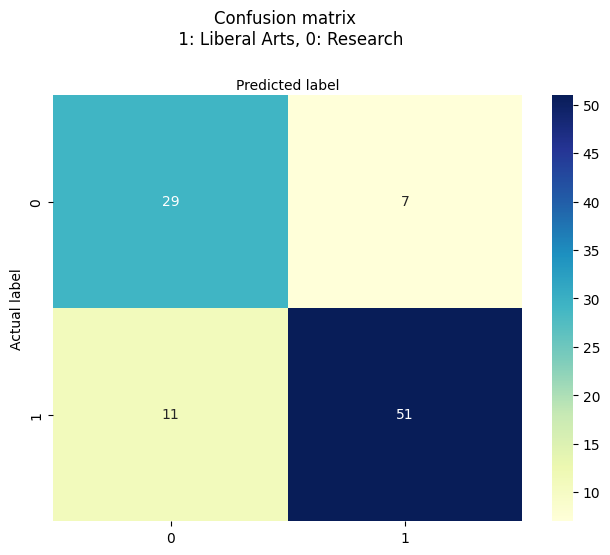

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
#Visualizing Confusion Matrix using Heatmap

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix \n 1: Liberal Arts, 0: Research', y=1.1)

plt.ylabel('Actual label')
plt.xlabel('Predicted label')

From the confusion matrix, we can see that 65 of the liberal arts statements were predicted correctly, and 10 of the research statements were predicted correctly. More of the research schools were predicted to be liberal arts.

### Classification Report

In [20]:
from sklearn.metrics import classification_report
target_names = [ 'research', 'liberal-arts']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    research       0.72      0.81      0.76        36
liberal-arts       0.88      0.82      0.85        62

    accuracy                           0.82        98
   macro avg       0.80      0.81      0.81        98
weighted avg       0.82      0.82      0.82        98



## Feature selection

In [21]:
# Use feature names from TFIDF Vectorizer and coefficients from logistic regression model
# Make data frame of terms and corresponding coefficient
coef_df = pd.DataFrame(zip(v.get_feature_names_out(), np.transpose(lr.coef_)), columns=['features', 'coef'])
coef_df['coef'] = coef_df['coef'].apply(lambda x: x[0])
coef_df.sort_values(by='coef', ascending= False, inplace=True)
coef_df.head(20)

,features,coef
855,college,2.462645
686,campus,0.670438
557,barnard,0.596159
1025,council,0.586896
777,chatham,0.576112
183,740,0.556278
3582,students,0.543408
2318,liberal,0.535198
3388,sex,0.534915
113,351,0.532990


In [22]:
# Select the top 30 words from both classes
selected_df = coef_df.iloc[np.r_[0:30, -30:-1]] 

# 'mount', 'chatham', numbers, 'mcla', 'lawrence', 'saint', 'wesleyan', 'davidson', 'thomas', 'harvard'

### Multicollinearity

In [23]:
# get indexes of all selected words
idxes = selected_df.index.tolist()

# zip list of terms and their index  
selected_terms = selected_df['features'].tolist()
selected_zip = list(zip(idxes, selected_terms))

# dictionary of tfidf scores for each term in all documents
selected_tfidf_dict = {i:[] for i in selected_terms}

for e, doc in enumerate(X_array):
    for i, term in selected_zip:
        selected_tfidf_dict[term].append(doc[i])

In [24]:
# correlation table
selected_tfidf_df = pd.DataFrame(selected_tfidf_dict)
corr = selected_tfidf_df.corr()

<Axes: >

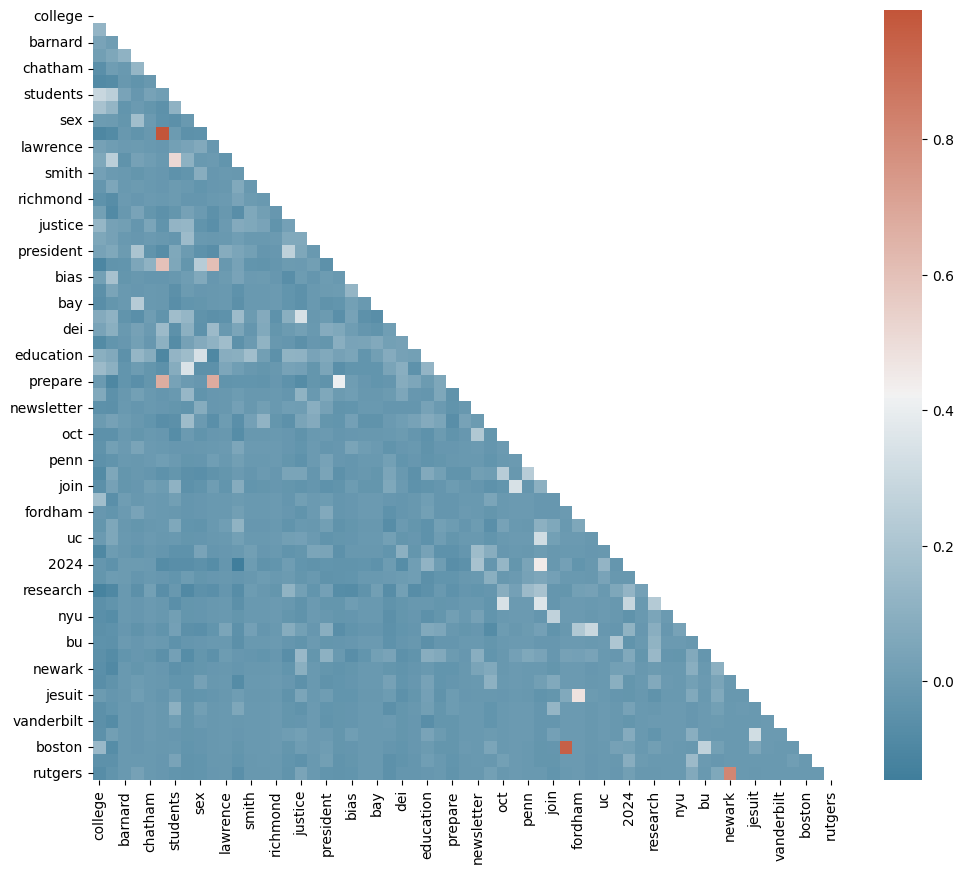

In [25]:
# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(12, 10))
# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap
sns.heatmap(corr, mask = mask, cmap=cmap)

## Remove other domain words
### School names, numbers

In [26]:
import re

In [172]:
conn = sqlite3.connect("deidatastore.db")
c = conn.cursor()


inst_df = pd.read_sql(f"""
select 
DISTINCT(u.unitid)
, instnm

from  usnews u
left join scorecard s on u.unitid = s.unitid""", conn)

In [173]:
inst_df

,unitid,instnm
0,168342,Williams College
1,164465,Amherst College
2,164155,United States Naval Academy
3,121345,Pomona College
4,216287,Swarthmore College
...,...,...
534,201885,University of Cincinnati-Main Campus
535,176017,University of Mississippi
536,106397,University of Arkansas
537,204857,Ohio University-Main Campus


In [174]:
all_college = " ".join(inst_df['instnm'].dropna()).lower()  # lowercase 
college_names = re.findall(r'\b\w+\b', all_college)  # Extract words only, ignoring punctuation

# Get unique words
college_names = list(set(college_names))

In [175]:
# Update stop words
from nltk.corpus import stopwords
 
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thaochu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [176]:
custom_stopwords = stopwords.words('english')
custom_stopwords.extend(college_names)

In [177]:
'university' in custom_stopwords

True

In [178]:
# Fit transform tfidf
v = TfidfVectorizer(max_df = .95, min_df = 3, stop_words = custom_stopwords, use_idf=True, norm = 'l2')
transformed_txt = v.fit_transform(txt_list)

X_array = transformed_txt.toarray()

In [179]:
len(v.get_feature_names_out())

doc_dfs = []

for counter, doc in enumerate(X_array):
    # construct a dataframe
    tf_idf_tuples = list(zip(v.get_feature_names_out(), doc))
    one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
    doc_dfs.append(one_doc_as_df)

In [180]:
print(doc_dfs[5][:15])
#22
#5
#26

         term     score
0   belonging  0.406117
1         byu  0.398080
2      christ  0.354440
3       jesus  0.256362
4         god  0.201986
5        love  0.167678
6     unified  0.138216
7         son  0.138216
8      gospel  0.138216
9   objective  0.128181
10   composed  0.124366
11     hearts  0.124366
12     father  0.124366
13  centering  0.121062
14       knit  0.121062


In [181]:
# Create a list (or list-like object) of the binary training/test labels for each text

df_text['category'] = df_text['type'].map({'liberal-arts': 1, 'research': 0})
labels = df_text['category']

In [182]:
# split the data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_array, labels, test_size=0.25, random_state=12)
X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01854185],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [183]:
# train
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

# use model to predict
results = lr.predict(X_test)
results

array([1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1])

In [184]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, results)

0.7448979591836735

In [185]:
# import the metrics class
from sklearn import metrics

y_pred =lr.predict(X_test)

In [186]:
#Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[22, 14],
       [11, 51]])

Text(0.5, 427.9555555555555, 'Predicted label')

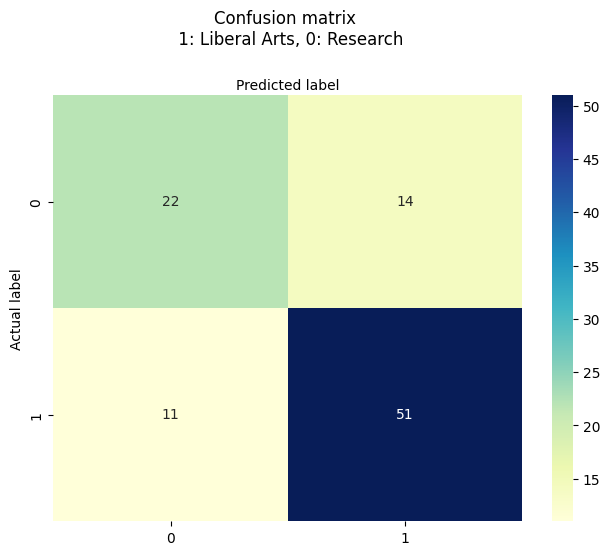

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt
#Visualizing Confusion Matrix using Heatmap

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix \n 1: Liberal Arts, 0: Research', y=1.1)

plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [188]:
from sklearn.metrics import classification_report
target_names = [ 'research', 'liberal-arts']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    research       0.67      0.61      0.64        36
liberal-arts       0.78      0.82      0.80        62

    accuracy                           0.74        98
   macro avg       0.73      0.72      0.72        98
weighted avg       0.74      0.74      0.74        98



In [189]:
# Use feature names from TFIDF Vectorizer and coefficients from logistic regression model
# Make data frame of terms and corresponding coefficient
coef_df = pd.DataFrame(zip(v.get_feature_names_out(), np.transpose(lr.coef_)), columns=['features', 'coef'])
coef_df['coef'] = coef_df['coef'].apply(lambda x: x[0])
coef_df.sort_values(by='coef', ascending= False, inplace=True)
coef_df.head(20)

# Select the top 30 words from both classes
selected_df = coef_df.iloc[np.r_[0:30, -30:-1]] 
# selected_df.loc[selected_df['features'] == '[0-9]+']

In [192]:
print(selected_df[:20].to_latex(index=False))

\begin{tabular}{lr}
\toprule
features & coef \\
\midrule
student & 0.689150 \\
students & 0.662052 \\
council & 0.660286 \\
admission & 0.597587 \\
justice & 0.585435 \\
sex & 0.563696 \\
mcla & 0.552144 \\
dr & 0.545665 \\
president & 0.491593 \\
bias & 0.486194 \\
prepare & 0.475293 \\
dei & 0.454890 \\
another & 0.438521 \\
social & 0.415674 \\
education & 0.412840 \\
wi & 0.406684 \\
developing & 0.399603 \\
regarding & 0.381765 \\
clubs & 0.380198 \\
responsibility & 0.377932 \\
\bottomrule
\end{tabular}



In [118]:
# get indexes of all selected words
idxes = selected_df.index.tolist()

# zip list of terms and their index  
selected_terms = selected_df['features'].tolist()
selected_zip = list(zip(idxes, selected_terms))

# dictionary of tfidf scores for each term in all documents
selected_tfidf_dict = {i:[] for i in selected_terms}

for e, doc in enumerate(X_array):
    for i, term in selected_zip:
        selected_tfidf_dict[term].append(doc[i])
        
# correlation table
selected_tfidf_df = pd.DataFrame(selected_tfidf_dict)
corr = selected_tfidf_df.corr()

<Axes: >

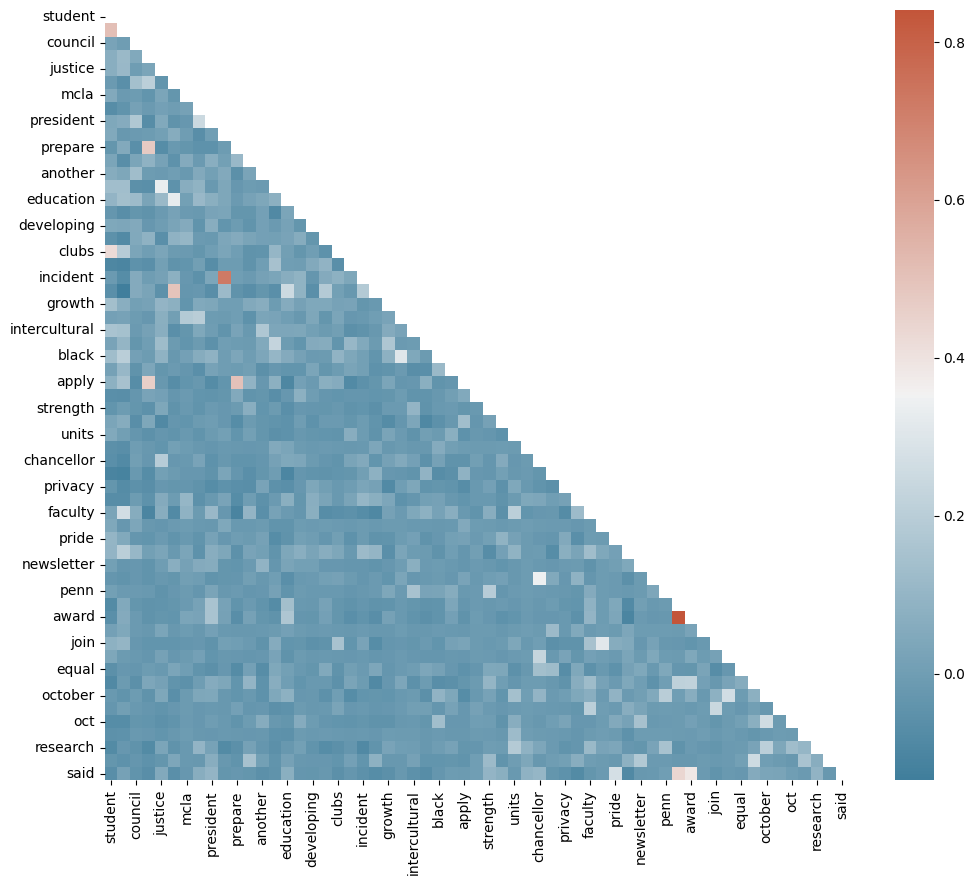

In [120]:
# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(12, 10))
# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap
sns.heatmap(corr, mask = mask, cmap=cmap)

In [128]:
import networkx as nx
import matplotlib.pyplot as plt

In [134]:
corr_threshold = 0.4
most_corr = corr.unstack().reset_index()

most_corr.columns = ['feature1', 'feature2', 'correlation']
filtered_corr = most_corr[
    (most_corr['correlation'] > corr_threshold) & (most_corr['feature1'] != most_corr['feature2'])
]

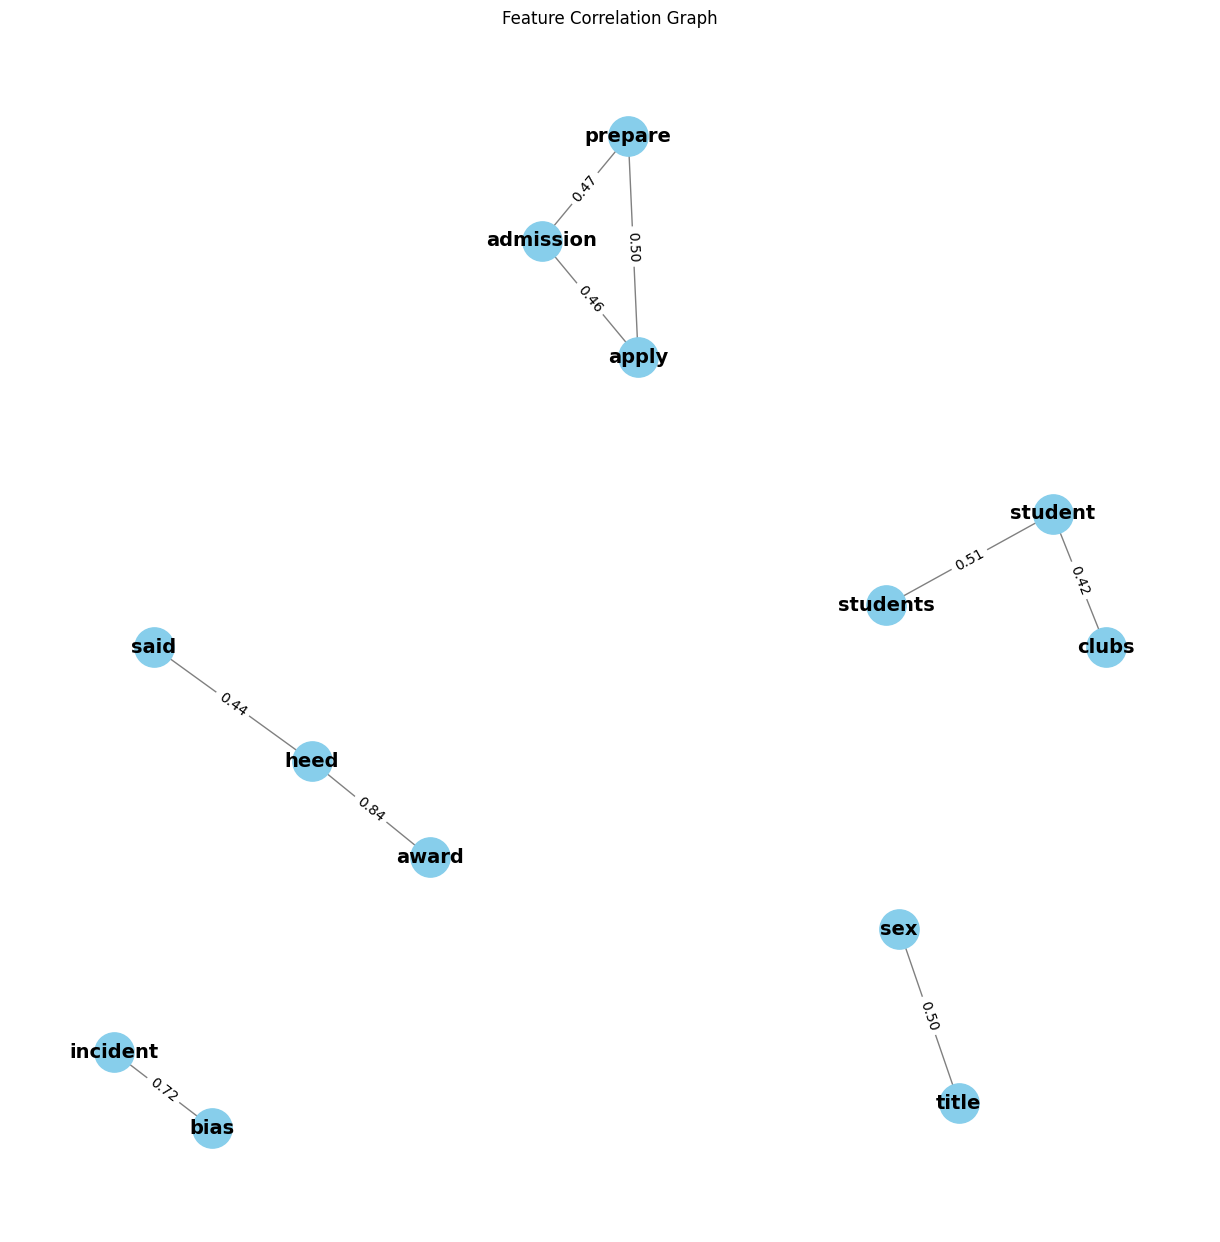

In [194]:
# Create a graph using NetworkX
G = nx.Graph()

# Add edges for each pair of correlated features
for _, row in filtered_corr.iterrows():
    G.add_edge(row['feature1'], row['feature2'], weight=row['correlation'])

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)  # Layout for visualization
nx.draw(
    G, pos,
    with_labels=True,
    node_size=800,
    node_color="skyblue",
    edge_color="gray",
    font_size=14,
    font_weight="bold"
)

# Add edge labels for correlation values
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()}
)

plt.title("Feature Correlation Graph")
plt.show()